In [2]:
# 라이브러리 및 데이터 준비
import pandas
import konlpy
import gensim
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
import pandas as pd
import os

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt') # 150000
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt') # 50000

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    x_train = list(map(wordlist_to_indexlist, X_train))
    x_test = list(map(wordlist_to_indexlist, X_test))
    
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}
print("데이터로드완료!")

데이터로드완료!


In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
# 모델 구성을 위한 데이터 분석 및 가공
# 데이터셋 내 문장 길이 분포
# 적절한 최대 문장 길이 지정
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
total_data_text = list(X_train) + list(X_test)
num_arrays = np.array([len(tokens) for tokens in total_data_text])

print('문장길이 평균 : ', np.mean(num_arrays))
print('문장길이 최소 : ', np.min(num_arrays))
print('문장길이 표준편차 : ', np.std(num_arrays))
print('단어길이 : ', len(word_to_index))

# 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_arrays) + 2 * np.std(num_arrays)
maxlen = int(max_tokens) # 41
print('적용최대 길이(maxlen) : ', maxlen)
print(f'전체 문장의 {np.sum(num_arrays < max_tokens) / len(num_arrays) * 100}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최소 :  0
문장길이 표준편차 :  12.843571191092
단어길이 :  10000
적용최대 길이(maxlen) :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
# tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
#raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype=object)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre', # pre or post
                                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre', # pre or post
                                                       maxlen=maxlen)

print(X_train[0])
print(get_decoded_sentence(X_train[0],index_to_word))

print(X_train[1])
print(get_decoded_sentence(X_train[1],index_to_word))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 1028    4   11  519
  549  687    5  120    4   70 1639   52  925 1006   15   44  391]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 흠 . .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나


In [7]:
# 1
vocab_size = len(word_to_index)  # 2336
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

"""
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()
"""

"""
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()
"""
print("각자!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________
각자!


In [8]:
# 약 15000건중 validation set 5000건 분리
x_val = X_train[:5000]   
y_val = y_train[:5000]

# validation set을 제외한 나머지 10000건
partial_x_train = X_train[5000:]  
partial_y_train = y_train[5000:]


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

Epoch 1/20
276/276 [==============================] - 5s 7ms/step - loss: 0.4775 - accuracy: 0.7844 - val_loss: 0.3407 - val_accuracy: 0.8554
Epoch 2/20
276/276 [==============================] - 1s 5ms/step - loss: 0.3366 - accuracy: 0.8579 - val_loss: 0.3294 - val_accuracy: 0.8568
Epoch 3/20
276/276 [==============================] - 1s 5ms/step - loss: 0.3172 - accuracy: 0.8667 - val_loss: 0.3295 - val_accuracy: 0.8606
Epoch 4/20
276/276 [==============================] - 1s 5ms/step - loss: 0.3058 - accuracy: 0.8732 - val_loss: 0.3316 - val_accuracy: 0.8584
Epoch 5/20
276/276 [==============================] - 1s 5ms/step - loss: 0.2960 - accuracy: 0.8775 - val_loss: 0.3332 - val_accuracy: 0.8582
Epoch 6/20
276/276 [==============================] - 1s 5ms/step - loss: 0.2873 - accuracy: 0.8818 - val_loss: 0.3343 - val_accuracy: 0.8590
Epoch 7/20
276/276 [==============================] - 1s 5ms/step - loss: 0.2777 - accuracy: 0.8862 - val_loss: 0.3352 - val_accuracy: 0.8586
Epoch 

In [9]:
print(results)
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

[0.4972900152206421, 0.8423418998718262]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


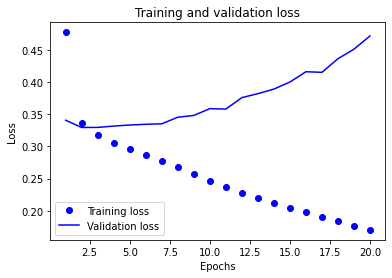

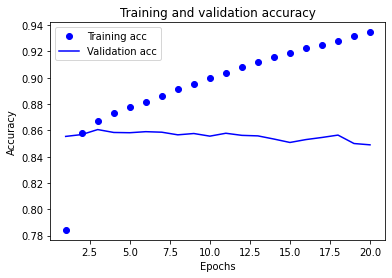

In [10]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [11]:
# 임베딩 레이어 유사도 데이터 저장
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/my_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [12]:
# 유사 데이터 찾기!
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("망함")

[('박은혜', 0.970156192779541),
 ('동기', 0.9685296416282654),
 ('멀리', 0.9617111086845398),
 ('싸구려', 0.9558930993080139),
 ('따분', 0.9529833793640137),
 ('2001', 0.9513324499130249),
 ('미화', 0.949306070804596),
 ('구토', 0.9473234415054321),
 ('강정', 0.9461077451705933),
 ('정준하', 0.9454864263534546)]

> Word2Vec 사용해보자

In [13]:
# Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
#vector = word_vectors.wv[‘끝’]

In [14]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
print(len(embedding_matrix))
# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv.index_to_key:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

[[6.36370052e-01 9.78972357e-01 6.66880402e-01 ... 2.16982268e-01
  9.59130304e-01 5.20544137e-01]
 [8.10109067e-01 3.71584166e-02 9.99162680e-01 ... 7.96018438e-01
  6.23457054e-01 9.60723147e-01]
 [6.29580631e-01 8.83558166e-01 5.51239749e-01 ... 3.54985118e-01
  4.38432995e-01 8.07240889e-02]
 ...
 [6.42847459e-04 2.86402970e-01 7.41066082e-01 ... 1.40518837e-01
  9.27213273e-01 2.94501838e-01]
 [4.78620575e-01 5.94995047e-01 8.93910735e-01 ... 6.81181344e-01
  8.88606051e-01 5.47282500e-04]
 [7.50960166e-01 4.15261744e-01 4.86981277e-01 ... 5.30819378e-01
  5.05926593e-01 8.49641567e-01]]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            11216     
________________________________________________

In [15]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3625 - accuracy: 0.8464
[0.3624669313430786, 0.8464104533195496]


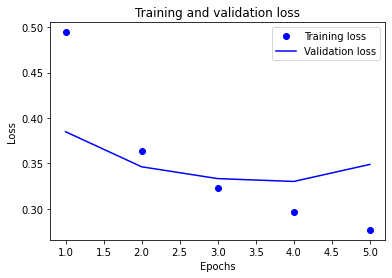

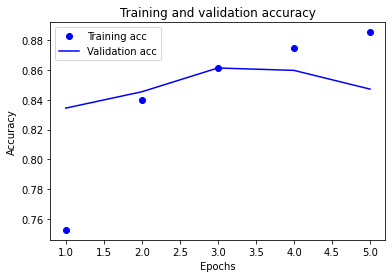

In [16]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()